In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from pythonlibs.torch_lib1 import *

print(README)

Common Library for PyTorch
Author: M. Akaishi


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(classes)
print(n_output)

10


In [6]:
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [7]:
data_root = './data'

train_set = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform_train
)

test_set = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 50

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## 모델 만들기

### Basic Block

In [9]:
from typing import Optional

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes:int, planes:int, stride:int=1,
                 downsample:Optional[nn.Module]=None, groups:int=1,
                 dilation:int=1, norm_layer:Optional[nn.Module]=None):
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, groups=groups, bias=False,
                               dilation=dilation)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplane=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=dilation, groups=groups, bias=False,
                               dilation=dilation)
        self.bn2 = norm_layer(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Bottleneck

In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes:int, planes:int, stride:int=1,
                 downsample:Optional[nn.Module]=None, groups:int=1,
                 base_width:int=64, dilation:int=1,
                 norm_layer:Optional[nn.Module]=None):
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        width = int(planes*(base_width / 64.)) * groups

        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, stride=1, bias=False)
        self.bn1 = norm_layer(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=dilation, groups=groups, dilation=dilation,
                               bias=False)
        self.bn2 = norm_layer(width)

        self.conv3 = nn.Conv2d(width, planes*self.expansion, kernel_size=1,
                               stride=1, bias=False)
        self.bn3 = norm_layer(planes*self.expansion)

        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [13]:
from typing import Type, List, Optional

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes:int, planes:int, stride:int=1,
                 downsample:Optional[nn.Module]=None, groups:int=1,
                 dilation:int=1, norm_layer:Optional[nn.Module]=None):
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3,
                               stride=stride, padding=dilation,
                               groups=groups, bias=False, dilation=dilation)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=dilation, groups=groups, bias=False,
                               dilation=dilation)
        self.bn2 = norm_layer(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet18(nn.Module):
    def __init__(self, block:Type[nn.Module], layers:List[int],
                 num_classes:int=1000, groups:int=1,
                 width_per_group:int=64,
                 norm_layer:Optional[nn.Module]=None):
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, block:Type[nn.Module], planes:int,
                    blocks:int, stride:int=1) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1,
                          stride=stride, bias=False),
                self._norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, groups=self.groups, 
                        dilation=self.dilation, norm_layer=self._norm_layer)]
        self.inplanes = planes * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride=1, downsample=None, groups=self.groups, 
                                dilation=self.dilation, norm_layer=self._norm_layer))
            
        return nn.Sequential(*layers)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def resnet18(num_classes:int=1000, norm_layer:Optional[nn.Module]=None) -> ResNet18:
    return ResNet18(
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        num_classes=num_classes,
        norm_layer=norm_layer
    )
    
net = resnet18(num_classes=10)

In [14]:
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [15]:
net = net.to(device)
summary(net, (100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [16]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [20]:
num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.00959 acc: 0.83262 val_loss: 0.01072, val_acc: 0.81930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00873 acc: 0.84912 val_loss: 0.00957, val_acc: 0.84000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00793 acc: 0.86216 val_loss: 0.00907, val_acc: 0.84590


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00718 acc: 0.87492 val_loss: 0.00870, val_acc: 0.85760


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00660 acc: 0.88578 val_loss: 0.00858, val_acc: 0.85820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00595 acc: 0.89696 val_loss: 0.00899, val_acc: 0.84850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00554 acc: 0.90432 val_loss: 0.00849, val_acc: 0.86680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00500 acc: 0.91276 val_loss: 0.00765, val_acc: 0.87410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00460 acc: 0.91930 val_loss: 0.00883, val_acc: 0.86500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00423 acc: 0.92626 val_loss: 0.00799, val_acc: 0.87130


초기상태 : 손실 : 0.01072  정확도 : 0.81930
최종상태 : 손실 : 0.00799 정확도 : 0.87130


c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.

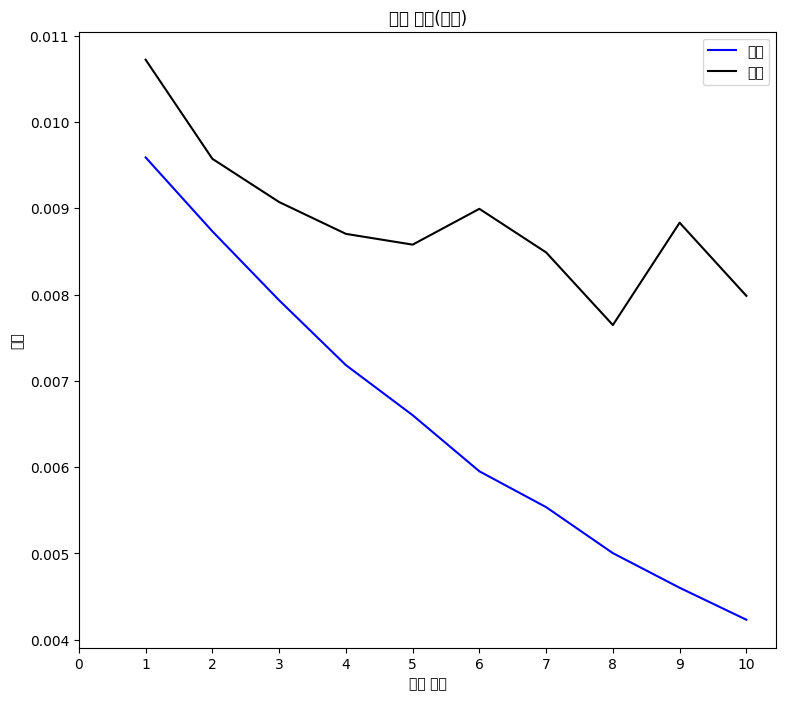

c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


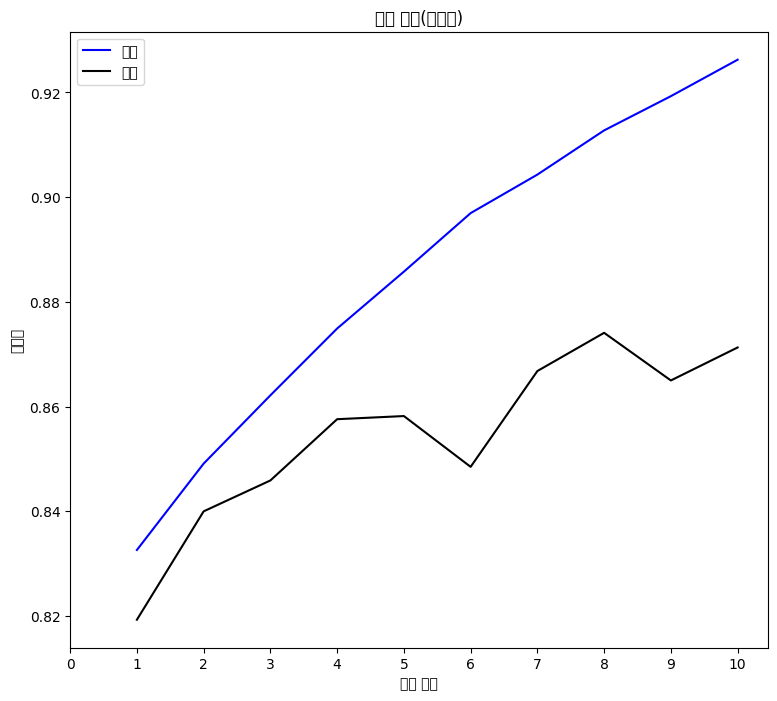

In [21]:
evaluate_history(history)

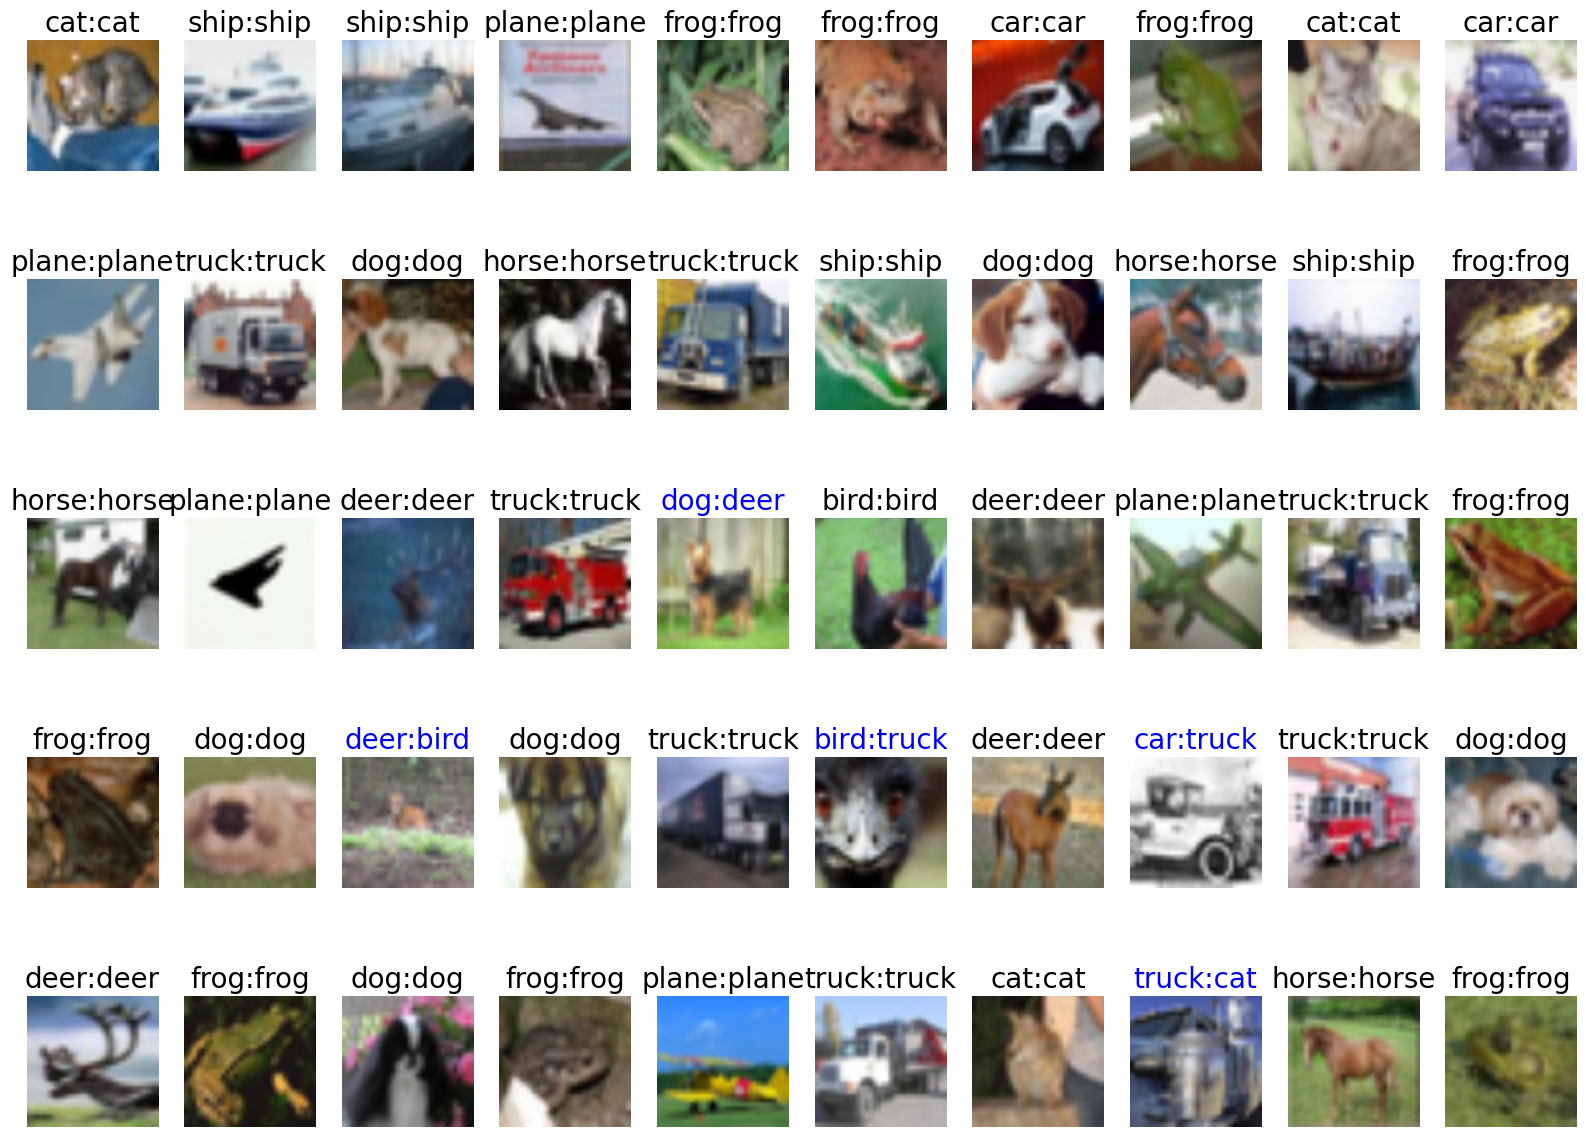

In [22]:
show_images_labels(test_loader, classes, net, device)